# Lab 2: Learning and convolutional neural networks
You will find the complete lab manual in this file. Some exercises require written answers, while others require coding.

**Important:** Do **not** define functions directly in this notebook. Instead, save them in the `functions.py` file and call them from the code cells in this notebook.

### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. Your **`functions.py`** file containing all function definitions.
3. A **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML

First, we'll import a set of python packages you'll need for this lab.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob

import scipy.io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

## Task 1: Learning a Linear Classifier

In this part, we will try to learn a linear classifier for blood cell detection. Note that the classifier could also be viewed as a minimal neural network consisting of three parts: a scalar product node (or fully-connected node), a constant (or bias) term and a logistic sigmoid function. To find good parameters we will try to minimize the negative log-likelihood over a small training set.

The output from our classifier is a probability $p$ for the input patch being centered at a cell centre. The sigmoid function will make sure that $0\leq p \leq 1$. To be more precise the output is
\begin{equation}p = \frac{e^y}{1+e^y} \quad \text{where} \quad y=I\cdot \omega + \omega_0\end{equation}
Instead of testing a bunch of manually chosen $\omega$’s and $\omega_0$’s, we will try to learn good values for all the parameters. This requires training examples, that you find in `fg_patches.npy` and `bg_patches.npy`.

### Task 1.1
Load the data

In [2]:
fg_patches = np.load("data/fg_patches.npy")
bg_patches = np.load("data/bg_patches.npy")

It loads two numpy arrays, fg_patches and bg_patches, corresponding to positive (centered blood cells) and negative examples respectively.

### Task 1.2


Create two new variables, examples and labels. The variable `examples` should be an array containing all the patches (both positives and negatives) and `labels` should be an array with the same number of elements such that `labels[i] = 1` if `examples[i]` is a positive example, and `labels[i] = 0` otherwise.

In [3]:
# Your code here

examples = np.concatenate((fg_patches, bg_patches))
labels = np.zeros(fg_patches.shape[0] + bg_patches.shape[0])
labels[0:fg_patches.shape[0]] = 1

### Task 1.3
Split the data into training, (`examples_train`, `labels_train`), and validation, (`examples_val`, `labels_val`). The two should have a similar structure to `examples` and `labels`. The splitting of the data into the two sets should be done in a random manner, for example using `np.random.permutation` to shuffle the indices. Write what percentage of data you use for training and validation respectively.

**Percentage of data used for training:** 80%

**Percentage of data used for validation:** 20%

In [4]:
# Your code here

# Random permutation of the patches
idx_permutation = np.random.permutation(len(labels))
examples_permutation = examples[idx_permutation]
labels_permutation = labels[idx_permutation]
# Set percentage of data for training and validation
percentage_validation = 0.2
percentage_training = 1 - percentage_validation
train_size = int(percentage_training * len(labels))
val_size = len(labels) - train_size
print(f"{train_size} images for training  and {val_size} images for validation")
# Split the data
examples_train = examples_permutation[0:train_size]
labels_train = labels_permutation[0:train_size]
examples_val = examples_permutation[train_size:]
labels_val = labels_permutation[train_size:]

320 images for training  and 80 images for validation


## Task 2: Training the Classifier
We will try to find parameters that minimize the negative log-likelihood on the training data. More precisely,
\begin{equation}
L(\theta) = \sum_{i\in S_+}-ln(p_i)+ \sum_{i\in S_-}-ln(1-p_i) = \sum_i L_i (\theta)
\end{equation}

where $p_i$ refers to the classifier output for the i'th training example. As in the lectures we will refer to the terms here as the partial loss $L_i$.

Before doing the next exercise, you need to work out how to compute the gradient of the partial loss $L_i$.

### Task 2.1
Make a function `partial_gradient` that computes the derivatives of the partial loss $L_i$ with respect to each of the classifier parameters. Place it in your `functions.py` file.

In [5]:
# def partial_gradient(w, w0, example_train, label_train):
#     ...
#     return wgrad, w0grad

**Comment:** <br>
The derivatives of the partial loss $L_i$ were computed by applying the chain rule. 
\begin{equation}
\frac{\partial L}{\partial w}=\frac{\partial L_i}{\partial p}\frac{\partial p}{\partial y}\frac{\partial y}{\partial w}
\end{equation}
\begin{equation}
\frac{\partial L}{\partial w_0}=\frac{\partial L_i}{\partial p}\frac{\partial p}{\partial y}\frac{\partial y}{\partial w_0}
\end{equation}
Considering an image $I$, weight $w$ and bias$w_0$, the response is $y=I \cdot w + w_0$ and the probability is a sigmoid function $p=\frac{e^{y}}{1 + e^{y}}$. <br>
Therefore, for positive examples:
\begin{equation}
\frac{\partial L}{\partial w}=-\frac{1}{p}\frac{\partial p}{\partial y}\frac{\partial y}{\partial w}=-\frac{1}{p}p(1-p)\frac{\partial y}{\partial w}=(p-1)I
\end{equation}
\begin{equation}
\frac{\partial L}{\partial w_0}=-\frac{1}{p}\frac{\partial p}{\partial y}\frac{\partial y}{\partial w_0}=-\frac{1}{p}p(1-p)\frac{\partial y}{\partial w_0}=(p-1)
\end{equation}
Similarly, for negative examples:
\begin{equation}
\frac{\partial L}{\partial w}=\frac{1}{1-p}\frac{\partial p}{\partial y}\frac{\partial y}{\partial w}=\frac{1}{1-p}p(1-p)\frac{\partial y}{\partial w}=pI
\end{equation}
\begin{equation}
\frac{\partial L}{\partial w_0}=\frac{1}{1-p}\frac{\partial p}{\partial y}\frac{\partial y}{\partial w_0}=\frac{1}{1-p}p(1-p)\frac{\partial y}{\partial w_0}=p
\end{equation}
Since `label_train`, is equal to 1 for positive examples and to 0 for negative examples, it is possible to express the derivatives of the partial loss in one expression: 
\begin{equation}
\frac{\partial L_i}{\partial w}=\text{label\_train}_i(p_i-1)I + (1-\text{label\_train}_i)p_iI
\end{equation}
\begin{equation}
\frac{\partial L_i}{\partial w_0}=\text{label\_train}_i(p_i-1) + (1-\text{label\_train}_i)p_i
\end{equation}

### Task 2.2
At each iteration of stochastic gradient descent, a training example, $i$, is chosen at random. For this example the gradient of the partial loss, $L_i$, is computed and the parameters are updated according to this gradient. The most common way to introduce the randomness is to make a random reordering of the data and then going through it in the new order. One pass through the data is called an epoch.

Make a function `process_epoch` that performs one epoch of stochastic gradient descent, and place it in your `functions.py` file.

In [6]:
# def process_epoch(w, w0, lrate, examples_train, labels_train, random_order=True):
#     ...        
#     return w, w0

**Comment:** <br>
The stochastic gradient descent compute the gradeint of the partial loss function with respect to a single, randomly chosen training example at each iteration. The goal is to find the optimal parameters: the weights $w$ and the bias $w_0$. At each iteration $k+1$, knowing the gradient of the loss with respect to $x$ at iteration $k$ and the learning rate $\mu$, the parameters can be updated as follows:  
\begin{equation}
w^{(k+1)}=w^{(k)}-\mu\sum_{i}\nabla L_i(w^{(k)})=w^{(k)}\mu\nabla L_i(w^{(k)})
\end{equation}
\begin{equation}
w_0^{(k+1)}=w_0^{(k)}-\mu\sum_{i}\nabla L_i(w_0^{(k)})=w_0^{(k)}\mu\nabla L_i(w_0^{(k)})
\end{equation}

### Task 2.3
Initialize `w = s * randn(35,35)`, with `s = 0.01` and `w0 = 0`; and run 5 epochs on your training examples. Plot `w` after each epoch (or after each iteration if you are curious), to get a sense of what is happening. Also, try using different `s=[10,1,0.1,0.01]` and plot `w` after 5 epochs for each value of `s`. Include on the report visualizations of w for the different values of `s`, along with an written explanation of what is happening.

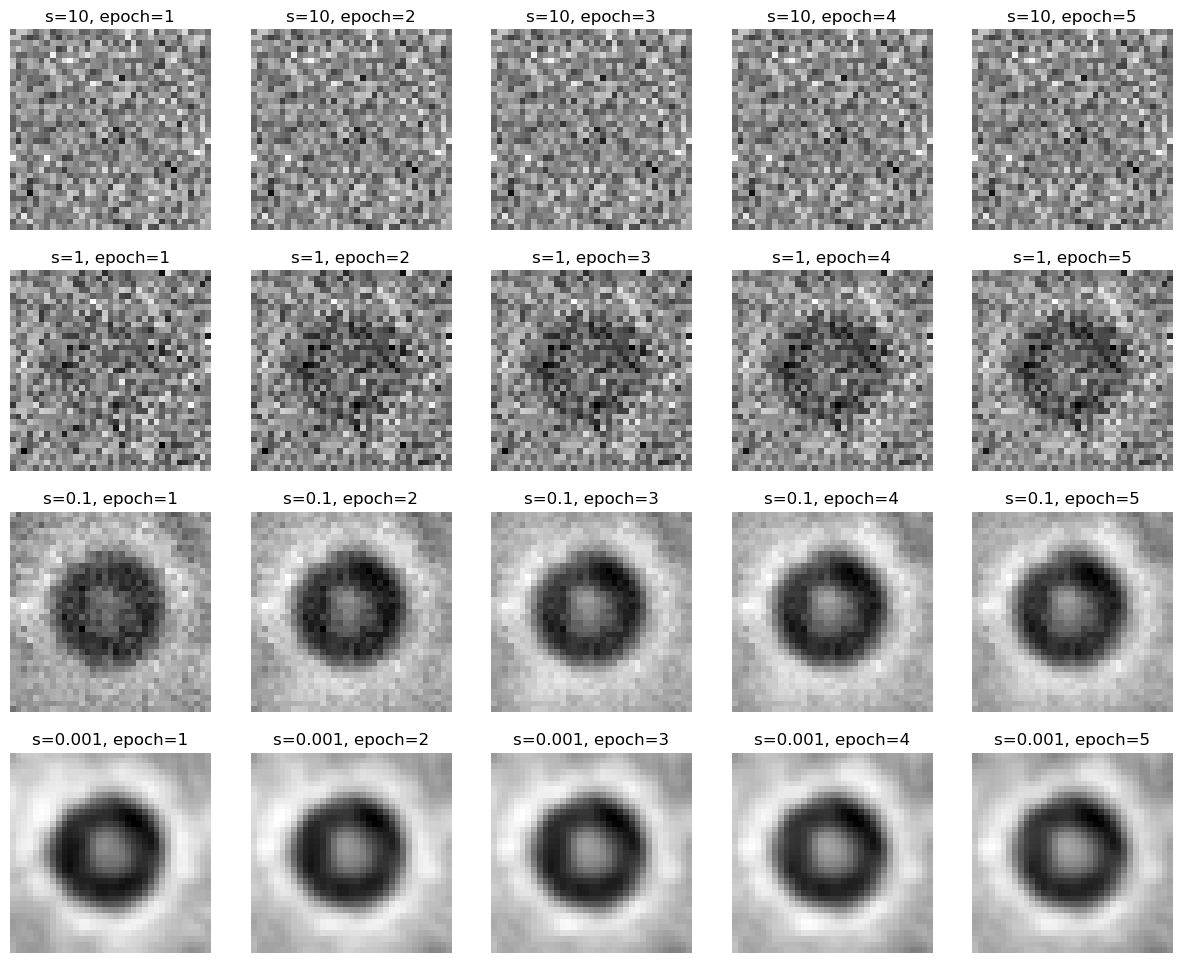

In [7]:
from functions import process_epoch
# Your code here

s_range = [10,1,0.1,0.001]
num_epochs = 5
lrate = 0.1

fig, axs = plt.subplots(len(s_range), num_epochs, figsize=(num_epochs * 3, len(s_range) * 3))
for s_idx, s in enumerate(s_range):
    # Initialize weight and bias
    dim = examples_train[0].shape
    w = s * np.random.randn(dim[0],dim[1])
    w0 = 0.0
    # Training for different reordering of the data 
    for epoch in range(num_epochs):
        w, w0 = process_epoch(w, w0, lrate, examples_train, labels_train, random_order=True)
        # Display w after the current epoch
        ax = axs[s_idx, epoch]
        im = ax.imshow(w, cmap='gray')
        ax.set_title(f"s={s}, epoch={epoch+1}")
        ax.axis('off')
plt.show()

**Your answer:** <br>
Starting from random weights, $w$, and with a zero bias, $w_0$, the stochastic gradient descent was used optimize the parameters. <br>
At each epoch, the `process_epoch` applies stochastic gradient descent to update $w$, initialized as random, and $w_0$, initialized at $0$, using gradients computed on single training examples, randomly shuffled at each epoch. <br>
The weights were correctly optimized for $s=0.1$ and $0.01$. Specifically, optimization was better for $s=0.1$ compared to $s=0.01$. <br>
This beahvior can be explained considering the sigmoid function . A scaling factor $s=10$ results in too large initialized weights and too large response $y=I\cdot w + w_0$, leading to the saturation of the sigmoid function, $p = \frac{e^y}{1+e^y}$. Since the sigmoid function remains constant at $1$, gradients are close to zero. Therefore, the weights do not update and the training will not converge. Instead, training begins with $s=1$, meaning that the initialization of the weights is more reasonable. However, weights update very slowly and the training will not converge in 5 epochs. Convergence occurs with a smaller scaling factor, $s=0.1$ or $s=0.01$. The initialized weights are small enough to avoid saturation and to produce a meaningful change in the gradients. From a visual inspection, weights obtained with $s=0.01$ appear more blurred. This can be attributed to the fact that the initialized weights are closer to each other, leading to a slower update, making the learned features less distinct.

### Task 2.4
As said before, at each iteration of stochastic gradient descent, a training example is chosen at random. Check what happens to $w$ after 5 epochs when that training example is not chosen randomly but in sequence, i.e. first $i = 1$, then $i = 2$, and so on. Include in the report a visualization of $w$ for this case. (Don’t forget to change back your function to a random choice of $i$ after this exercise).


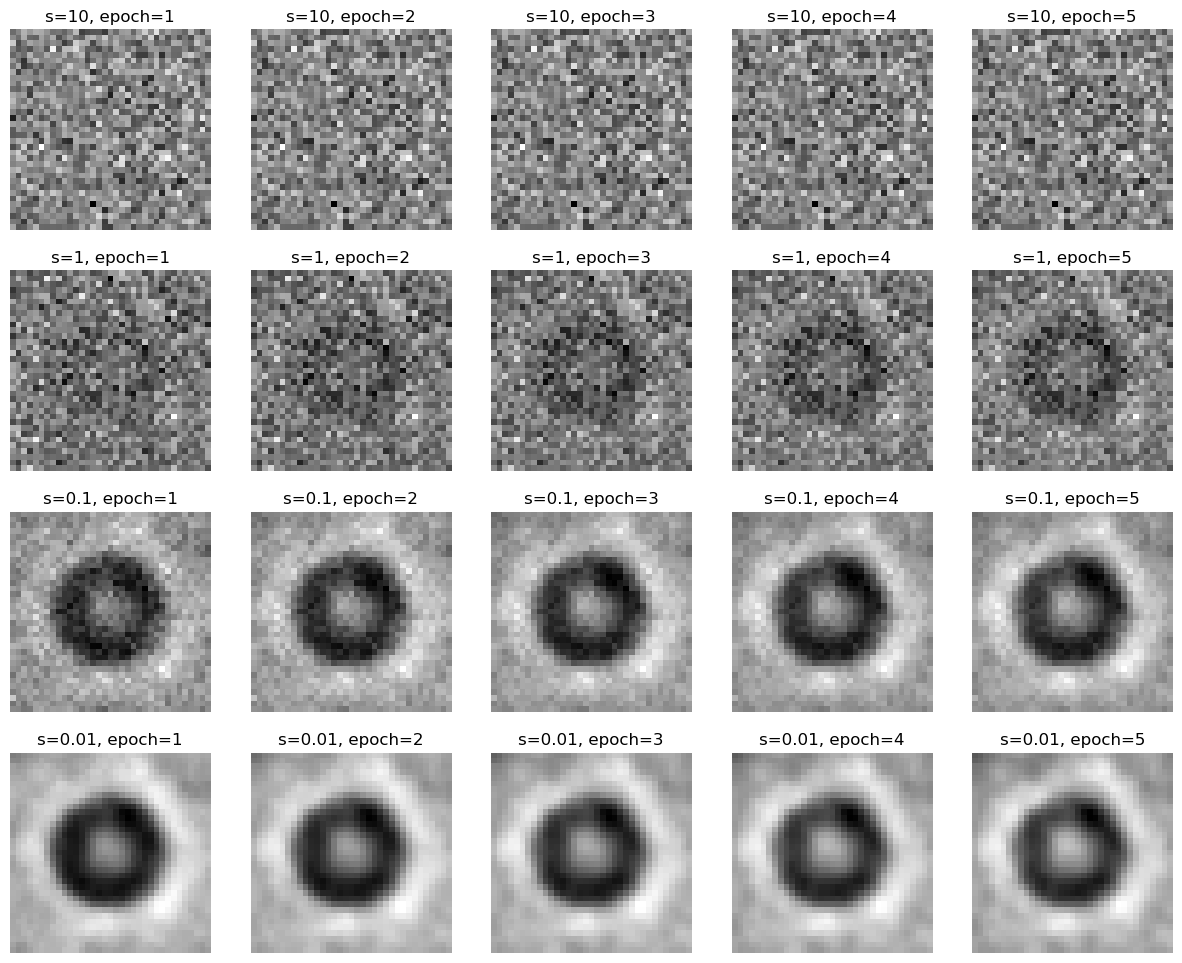

In [8]:
# Your code here

s_range = [10,1,0.1,0.01]
num_epochs = 5
lrate = 0.1
fig, axs = plt.subplots(len(s_range), num_epochs, figsize=(num_epochs * 3, len(s_range) * 3))
for s_idx, s in enumerate(s_range):
    # Initialize weight and bias
    dim = examples_train[0].shape
    w = s * np.random.randn(dim[0],dim[1])
    w0 = 0.0
    # Training for different reordering of the data 
    for epoch in range(num_epochs):
        w, w0 = process_epoch(w, w0, lrate, examples_train, labels_train, random_order=False)
        # Display w after the current epoch
        ax = axs[s_idx, epoch]
        im = ax.imshow(w, cmap='gray')
        ax.set_title(f"s={s}, epoch={epoch+1}")
        ax.axis('off')
plt.show()

### Task 2.5
Make a function `classify` that applies the classifier to the example data. After that, use it on `examples_train` and `examples_val` and check how much accuracy it gets for each by comparing the predicted labels with `labels_train` and `labels_val` respectively. Write on your report the highest accuracy you were able to achieve in the training and validation data. Hint: train the classifier for longer than 5 epochs to make sure that it converges.

In [9]:
# def classify(examples_val, w, w0):
#     ...
#     return predicted_labels

In [10]:
from functions import classify

# Initialization
s = 0.1
num_epochs = 5
lrate = 0.1
dim = examples_train[0].shape
w = s * np.random.randn(dim[0],dim[1])
w0 = 0.0
# Train the classifier
for epoch in range(num_epochs):
    w, w0 = process_epoch(w, w0, lrate, examples_train, labels_train, random_order=True)
# Apply the classifier to the training examples
predicted_labels_train = classify(examples_train,w,w0)
# Compute the accuracy
correct_train = sum(predicted_labels_train==labels_train)
accuracy_train = 100*correct_train/len(labels_train)
print(f"Training Accuracy: {accuracy_train}")
# Apply the classifier to the validation examples
predicted_labels_val = classify(examples_val,w,w0)
# Compute the accuracy
correct_val = sum(predicted_labels_val==labels_val)
accuracy_val = 100*correct_val/len(labels_val)
print(f"Validation Accuracy: {accuracy_val}")

Training Accuracy: 88.75
Validation Accuracy: 87.5


When you have defined the function run the following code.

In [11]:
predicted_labels = classify(examples_val,w,w0)
correct = sum(predicted_labels==labels_val)
accuracy = 100*correct/len(labels_val)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 87.5


**Write the highest accuracy you were able to get here:** 95.5

### Task 2.6
The data for training this classifier consists of only 400 examples (less if you consider that you have split it into training and validation). To achieve higher accuracy it might be useful to perform some data augmentation before the training. In this exercise you will increase the number of elements in the training examples by $M$ times. Make a function `augment_data` that takes each sample of the original training data and applies M random rotations (you can use function `scipy.ndimage.rotate`), resulting in $M$ new examples. Store these new examples in `examples_train_aug` and their corresponding labels in `labels_train_aug`.

In [12]:
# def augment_data(examples_train, labels_train, M):
#     ...
#     return examples_train_aug, labels_train_aug

Train the classifier with this augmented data and write on your report the new values for accuracy on the training and validation examples.

In [13]:
from scipy.ndimage import rotate
from functions import augment_data

# Your code here

# Augment training examples
M = 8
examples_train_aug, labels_train_aug = augment_data(examples_train, labels_train, M)
# Initialization
s = 0.1
num_epochs = 5
dim = examples_train_aug[0].shape
w = s * np.random.randn(dim[0],dim[1])
w0 = 0.0
# Train the classifier
for epoch in range(num_epochs):
    w, w0 = process_epoch(w, w0, lrate, examples_train_aug, labels_train_aug, random_order=True)
# Apply the classifier to the training examples
predicted_labels_train = classify(examples_train_aug,w,w0)
# Compute the accuracy
correct_train = sum(predicted_labels_train==labels_train_aug)
accuracy_train = 100*correct_train/len(labels_train_aug)
print(f"Training Accuracy with augmentation: {accuracy_train}")
# Apply the classifier to the validation examples
predicted_labels_val = classify(examples_val,w,w0)
# Compute the accuracy
correct_val = sum(predicted_labels_val==labels_val)
accuracy_val = 100*correct_val/len(labels_val)
print(f"Validation Accuracy with augmentation: {accuracy_val}")

Training Accuracy with augmentation: 93.515625
Validation Accuracy with augmentation: 96.25


In [14]:
predicted_labels = classify(examples_val,w,w0)
correct = sum(predicted_labels==labels_val)
accuracy = 100*correct/len(labels_val)
print(f"Validation Accuracy with augmentation: {accuracy}")

Validation Accuracy with augmentation: 96.25


**Write the highest accuracy you were able to get here:** 97.5

## Task 3: Convolutional neural networks
In the last part, your task is to train a convolutional neural networks using the python package pytorch.



### Task 3.1
Run the following cell to load MNIST, a dataset of images of digits. Plot a few of them to see what the data looks like.

54000 images for training  and 6000 images for validation
Batch of images: torch.Size([64, 1, 28, 28])
Batch of labels: torch.Size([64])


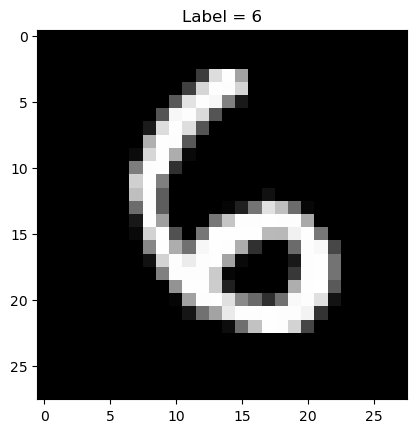

In [15]:
from supplied import load_mnist_training_validation
percentage_validation=0.1 # Define percentage of images to use for validation
batch_size = 64 # Define batch size
train_loader, val_loader = load_mnist_training_validation(percentage_validation,batch_size)


# Example: Load one batch from the dataloader
img_idx = 10 # Can try any index between 0 and (batch_size-1) 
for images, labels in train_loader:
    print(f"Batch of images: {images.shape}")
    print(f"Batch of labels: {labels.shape}")
    image = images[img_idx,0,:,:]
    label = labels[img_idx]
    plt.imshow(image,cmap="gray")
    plt.title(f"Label = {label}")
    break  # Just to show one batch

### Task 3.2
The next step is to define a network for classification. You should define a pytorch model that implements the following network:

![title](img/simple_cnn.png)

As a hint here is an example of how a simple pytorch network can be defined:

```
class simple_feedforward_network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(simple_feedforward_network, self).__init__()
        # Defining the layers needed for the network
        self.fc1 = nn.Linear(input_size, hidden_size)   # First fully connected layer
        self.relu = nn.ReLU()  # ReLU activation
        self.fc2 = nn.Linear(hidden_size, output_size)  # Output layer
    
    def forward(self, x):
        # Defining the forward pass
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
```

Apart from the layers used in the example above the functions `nn.Conv2d`, `nn.MaxPool2d` and `F.softmax` will be useful. Note that you have to set the stride for max pooling to 2 to get the expected downsampling.

You should fill in this template to design the asked for network.

In [16]:
class basic_cnn_classifier(nn.Module):
    def __init__(self):
        super(basic_cnn_classifier, self).__init__()
        # Your code here

        # Define the layers needed for your network
        self.conv = nn.Conv2d(1, 25, 3, 1)     # Convolutional layer
                                               # in_channels=1, out_channels=25, kernel_size=3, stride=1
        self.pool = nn.MaxPool2d(2, 2)         # Max pooling
                                               # kernel_size=2, stride=2
        self.fc = nn.Linear(25*13*13, 10)      # Fully connected layer
                                               # in_features=25*13*13, out_features=10

    def forward(self, x):
        # Your code here

        # Define the forward pass through the network
        x = self.conv(x)                   # Apply convolution
        x = F.relu(x)                      # Apply ReLU
        x = self.pool(x)                   # Apply max pooling
        x = self.fc(x.view(x.size(0), -1)) # Fully connected layer of flattened input
        x = F.softmax(x, 1)                # Softmax activation for output

        return x  # Output class propabilities

**Comment:** <br>To define the layers of the network it is important to analyze the inputs and outputs of each layer: 
- Input image is $1$ channel of dimension $28\times28$
- Convolutional layer with $25$ filters of dimension $3\times3$ without padding: $25$ output of dimension $26\times26$ 
- Activation function: output is unchanged
- Max pooling $2\times2$: $25$ output of dimension $13\times13$ 
- Fully connected layer with $10$ outputs: $10$ outputs
- Softmax: output is unchanged

### Task 3.3
You should now train the network using the following training loop defined in `train_model`.

In [17]:
from supplied import train_model

# Set device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training loop
num_epochs = 5
lr = 0.001

# Initialize model, loss function, and optimizer
basic_model = basic_cnn_classifier().to(device)
loss_fn = nn.NLLLoss ()  # Define the loss function
optimizer = optim.SGD(basic_model.parameters(), lr=lr)

basic_model_trained = train_model(basic_model, train_loader, val_loader, num_epochs, optimizer,loss_fn,device)

Epoch [1/5], Loss: -0.2820, Accuracy: 42.19%
Validation Accuracy: 63.08%
Epoch [2/5], Loss: -0.5519, Accuracy: 64.79%
Validation Accuracy: 66.33%
Epoch [3/5], Loss: -0.6087, Accuracy: 65.91%
Validation Accuracy: 66.63%
Epoch [4/5], Loss: -0.6280, Accuracy: 66.43%
Validation Accuracy: 67.18%
Epoch [5/5], Loss: -0.6386, Accuracy: 66.75%
Validation Accuracy: 67.50%
Training complete.


### Task 3.4
Work out how many trainable parameters your network contains. Note that the convolution layer does not use padding so the output from the convolution layer is smaller than the input.

**Write your answer here:** 42475

**Comment:** <br>
To compute the number of trainable parameters of the network it is important to analyze each layer:
- Input image is $1$ channel of dimension $28\times28$
- Convolutional layer with $25$ filters of dimension $3\times3$ without padding on $1$ input: $\#\text{CONV}=25\cdot3\cdot3\cdot1=225$
- Activation function: $\#\text{ReLU}=0$
- Max pooling: $\#\text{pool}=0$
- Fully connected layer with $10$ outputs on $25$ inputs of dimension $13\times13$: $\#\text{FCL}=10\cdot13\cdot13\cdot25=42250$
- Softmax: $\#\text{sMax}=0$
Therefore, only the convolutional and the fully connected layers have trainable parameters. 

### Task 3.5
To run a convolutional neural network we have to perform a massive amount of computations. Hence it is very important to consider the computational load when designing a network. For the network below, compare (roughly) the time consumption (number of computations required) for the blue and the red layers. You can ignore effects of padding. NOTE: You are not supposed to actually implement and train this network.


![title](img/blue_red_cnn.png)

**Write your answer here:** <br>
To compute the number of trainable parameters of the network it is important to analyze each layer:
- Input image assumed as $1$ channel of dimension $N\times N$
- Convolutional layer with $10$ filters of dimension $5\times5$ on $1$ input: $10$ output of dimension $N\times N$ 
- Activation function: output is unchanged
- Convolutional layer with $10$ filters of dimension $5\times5$ on $10$ inputs: $10$ output of dimension $N\times N$ 
- Activation function: output is unchanged
- Max pooling $2\times2$ on $10$ inputs: $10$ output of dimension $\frac{N}{2}\times\frac{N}{2}$
- Convolutional layer with $10$ filters of dimension $5\times5$ on $10$ inputs: $10$ output of dimension $\frac{N}{2}\times\frac{N}{2}$
- Activation function: output is unchanged
- Max pooling $2\times2$ on $10$ inputs: $10$ output of dimension $\frac{N}{4}\times\frac{N}{4}$
- Convolutional layer with $20$ filters of dimension $5\times5$ on $10$ inputs: $20$ output of dimension $\frac{N}{4}\times\frac{N}{4}$
- Activation function: output is unchanged <br>
<br>
To compute the time consumption, the number of pixels has to be taken into account:
- $\#\text{BLU}=10\cdot5\cdot5\cdot10\cdot N\cdot N=2500N^2$
- $\#\text{RED}=20\cdot5\cdot5\cdot10\cdot\frac{N}{4}\cdot\frac{N}{4}=312.5N^2$ <br>
<br>
Therefore, the time consumption of the red layer is lower, approximately $\frac{312.5}{250}=12.5\%$ of the time consumption of the blu layer.

### Task 3.6

Imagine that the blue box of the network in the figure above is replaced by a sequence of two layers of 10 3 × 3 convolutional filters. What changes in terms of network parameters, time consumption (number of computations) and accuracy would that lead to?


**Write your answer here:** <br>
The number of trainable parameters of the network with one convolutional layer with $10$ filters of dimension $5\times5$ is $10250$:
- $\#\text{CONV}\_1=10\cdot5\cdot5\cdot1=250$
- $\#\text{CONV}\_2=10\cdot5\cdot5\cdot10=2500$
- $\#\text{CONV}\_3=10\cdot5\cdot5\cdot10=2500$
- $\#\text{CONV}\_4=20\cdot5\cdot5\cdot10=5000$ <br>
<br>
The number of trainable parameters of the network with two convolutional layers with $10$ filters of dimension $3\times3$ is $9550$:
- $\#\text{CONV}\_1=10\cdot5\cdot5\cdot1=250$
- $\#\text{CONV}\_2=10\cdot3\cdot3\cdot10=900$
- $\#\text{CONV}\_3=10\cdot3\cdot3\cdot10=900$
- $\#\text{CONV}\_4=10\cdot5\cdot5\cdot10=2500$
- $\#\text{CONV}\_5=20\cdot5\cdot5\cdot10=5000$ <br>
<br>
The time consumption of the blu layer with one and two convolutional layers is respectively:
- $\#\text{BLU}[1]=10\cdot5\cdot5\cdot10\cdot N\cdot N=2500N^2$
- $\#\text{RED}[2]=2\cdot(10\cdot3\cdot3\cdot10\cdot N\cdot N)=18005N^2$ <br>
<br>
Therefore, the time consumption of the blu layer with two convolutional layers is lower, approximately $\frac{1800}{2500}=72\%$ of the time consumption of the blu layer. <br>
Convolutional layers detect local features. The first layers that are applied to the data learn to recognize simple features, while deeper layers capture more complex features.

### Task 3.7
Make a copy of `basic_cnn_classifier` and name it `better_cnn_classifier`. Try modifying the network by adding more layers. Also experiment with the training options. How much can you improve the results?

In [18]:
class better_cnn_classifier(nn.Module):
    def __init__(self):
        super(better_cnn_classifier, self).__init__()
        # Your code here

        # Define the layers needed for your network
        self.conv1 = nn.Conv2d(1, 25, 3, 1)  # Convolutional layer
        self.pool = nn.MaxPool2d(2, 2)          # Max pooling
        self.conv2 = nn.Conv2d(25, 50, 3, 1)  # Convolutional layer
        self.fc1 = nn.Linear(50*11*11, 10)        # Fully connected layer

    def forward(self, x):
        # Your code here
    
        # Define the forward pass through the network
        x = self.conv1(x)                   # Apply convolution
        x = F.relu(x)                       # Apply ReLU
        x = self.pool(x)                    # Apply max pooling
        x = self.conv2(x)                   # Apply convolution
        x = F.relu(x)                       # Apply ReLU
        x = self.fc1(x.view(x.size(0), -1)) # Fully connected layer of flattened input
        x = F.relu(x)                       # Apply ReLU
        x = F.softmax(x, 1)                 # Softmax activation for output
     
        return x # Output class propabilities

In [19]:
from supplied import train_model

# Set device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training loop
num_epochs = 10
lr = 0.001

# Initialize model, loss function, and optimizer
better_model = better_cnn_classifier().to(device)
loss_fn = nn.NLLLoss ()  # Define the loss function 
optimizer = optim.SGD(better_model.parameters(), lr=lr)

better_model_trained = train_model(better_model, train_loader, val_loader, num_epochs, optimizer,loss_fn,device)

Epoch [1/10], Loss: -0.1115, Accuracy: 21.14%
Validation Accuracy: 25.13%
Epoch [2/10], Loss: -0.2047, Accuracy: 31.79%
Validation Accuracy: 49.35%
Epoch [3/10], Loss: -0.4912, Accuracy: 62.18%
Validation Accuracy: 71.10%
Epoch [4/10], Loss: -0.6582, Accuracy: 72.27%
Validation Accuracy: 73.53%
Epoch [5/10], Loss: -0.6999, Accuracy: 73.75%
Validation Accuracy: 74.22%
Epoch [6/10], Loss: -0.7167, Accuracy: 74.39%
Validation Accuracy: 74.70%
Epoch [7/10], Loss: -0.7260, Accuracy: 74.79%
Validation Accuracy: 74.98%
Epoch [8/10], Loss: -0.7321, Accuracy: 75.04%
Validation Accuracy: 75.13%
Epoch [9/10], Loss: -0.7364, Accuracy: 75.23%
Validation Accuracy: 75.45%
Epoch [10/10], Loss: -0.7396, Accuracy: 75.41%
Validation Accuracy: 75.50%
Training complete.


**Comment:** <br>
To improve the accuracy,  preferred. As previously seen, adding convolutional layers reduce the amount of computation, leading to improved accruacy. Additionally, by increasing the number of epochs the accuracy improve too.

### Task 3.8
You should now take your model that gave best results on the validation set and evaluate it on the test set. Compute precision and recall for each of the 10 classes. The definitions of precision and recall can be found in the lecture notes chapter 4.

In [20]:
from supplied import load_mnist_test
test_loader = load_mnist_test() # Loading dataloader for test split

# Your code here
from sklearn.metrics import confusion_matrix

# Number of different classes
num_classes = 10
# Evaluate the model on the test set
better_model_trained.eval()
images = []
true_labels = []
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation for validation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = better_model_trained(inputs)
        _, predicted = torch.max(outputs, 1)
        for image, true_label, predicted_label in zip(inputs.cpu(), labels.cpu(), predicted.cpu()):
            images.append(image.numpy())                  
            true_labels.append(true_label.item())      
            predicted_labels.append(predicted_label.item())
total = np.zeros(10)
tp = np.zeros(10)
fn = np.zeros(10)
fp = np.zeros(10)
tn = np.zeros(10)
precision = np.zeros(10)
recall = np.zeros(10)
for c in range(num_classes):
    total[c] = true_labels.count(c)
    for i in range(len(true_labels)):
        if (true_labels[i] == c) & (predicted_labels[i] == c):
            tp[c] += 1
        elif (true_labels[i] == c) & (predicted_labels[i] != c):
            fn[c] += 1
        elif (true_labels[i] != c) & (predicted_labels[i] == c):
            fp[c] += 1
        elif (true_labels[i] != c) & (predicted_labels[i] != c):
            tn[c] += 1
    # Precision and recall
    precision[c] = tp[c] / (tp[c] + fp[c])
    recall[c] = tp[c] / (tp[c] + fn[c])
# Display precision and recall
print("\nPrecision and Recall per-Class :")
for c in range(num_classes):
    print(f"Class {c}: Precision = {precision[c]:.4f}, Recall = {recall[c]:.4f}")


Precision and Recall per-Class :
Class 0: Precision = 0.8842, Recall = 0.9816
Class 1: Precision = 0.9464, Recall = 0.9806
Class 2: Precision = 0.9138, Recall = 0.8624
Class 3: Precision = 0.7272, Recall = 0.9158
Class 4: Precision = 0.5664, Recall = 0.9593
Class 5: Precision = nan, Recall = 0.0000
Class 6: Precision = 0.8972, Recall = 0.9656
Class 7: Precision = 0.7309, Recall = 0.9329
Class 8: Precision = 0.6031, Recall = 0.9189
Class 9: Precision = nan, Recall = 0.0000


C:\Users\local_allegrag\Temp\ipykernel_19772\4165931863.py:42: RuntimeWarning: invalid value encountered in scalar divide
  precision[c] = tp[c] / (tp[c] + fp[c])


**Comment:** <br>
Knowing the number of $TP$, $FN$, $FP$ and $TN$, the precision and the recall can be derived. Specifically:
- the precision can be computed as: $\frac{TP}{TP+FP}$;
- the recall can be computed as: $\frac{TP}{TP+FN}$;

### Task 3.9
Show three cases where your model fails with names indicating what digit they were mistaken for. You can use `plt.imshow` show the images here. Have a look at the images before submitting it, so it looks right.

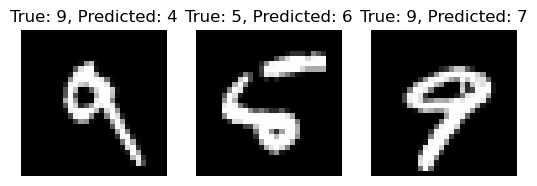

In [21]:
# Your code here

# Misclassification
false = []
for i in range(len(predicted_labels)):
    if true_labels[i] != predicted_labels[i]:
        false.append((images[i], true_labels[i], predicted_labels[i]))
    if len(false) >= 3:
        break

# Plot the misclassified images
plt.figure()
for idx, (image, true_label, predicted_label) in enumerate(false):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True: {true_label}, Predicted: {predicted_label}", fontsize=12)
    plt.axis('off')
plt.show()